In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import bisect
from levin import LevinIntegrator
from scipy.special import gamma, hyp1f1, j0
from scipy.integrate import quad, quad_vec
import mpmath as mp
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
import astropy.constants as const

# Takahashi Nakamura paper

ImportError: cannot import name 'LevinIntegrator' from 'levin' (/home/sparky/.local/lib/python3.10/site-packages/levin/__init__.py)

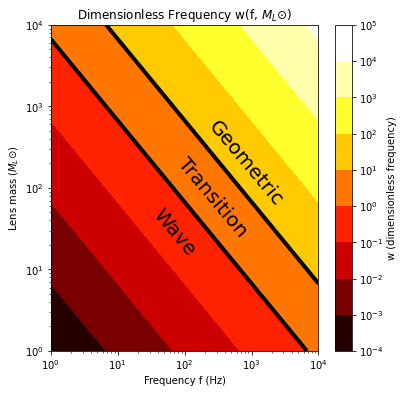

In [3]:
# Plotting dimensionless frequency (w) as function of frequency (f) and lens mass (M_L)
freq = np.linspace(1, 10000, 2000)
mass = np.linspace(1, 10000, 2000)

F, M = np.meshgrid(freq, mass)
W = w_f(F, M, 0.2)

plt.figure(figsize=(6, 6))
cp = plt.contourf(F, M, W, levels=100, cmap="hot", norm=LogNorm(vmin=W.min(), vmax=W.max()))
plt.xscale('log')
plt.yscale('log')
plt.colorbar(cp, label='w (dimensionless frequency)')

plt.contour(F, M, W, levels=[1], colors='black', linestyles='-',  linewidths=4)
plt.contour(F, M, W, levels=[10], colors='black', linestyles='-',  linewidths=4)
plt.text(30, 15, "Wave", color="black", fontsize=20, rotation=-50)
plt.text(70, 25, "Transition", color="black", fontsize=20, rotation=-50)
plt.text(200, 60, "Geometric", color="black", fontsize=20, rotation=-50)

plt.xlabel("Frequency f (Hz)")
plt.ylabel(r"Lens mass$ \;(M_L{\odot})$")
plt.title(r"Dimensionless Frequency w(f, $M_L{\odot}$)")
plt.savefig("w.png", dpi=600)
plt.show()

In [2]:
# LISA-Measured Signals

G = 6.6743e-11 # m^3 / (kg*s^2)
c = 299792458 # m/s
M_sun = 1.9891e30 # kg

# just to reduce L*n to cos(i) for now for full effect...
def L_vector(i):
    return np.array([np.sin(i), 0, np.cos(i)])
def n_vector():
    return np.array([0, 0, 1])

# chirp mass
def chirp_M(M1, M2):
    return (M1*M2)**(3/5) / (M1 + M2)**(1/5)

# redshifted chirp mass
def M_z(M1, M2, z_S):
    M1 = M1 * M_sun
    M2 = M2 * M_sun
    return chirp_M(M1, M2) * (1 + z_S)
    
# amplitude
def amplitude(z_S, M_z):
    D_S = cosmo.angular_diameter_distance(z_S).to('m').value
    return np.sqrt(5/96)*np.pi**(-2/3) * (G*M_z/c**3)**(5/6) / (D_S * (1+z_S)**2)

def psi_f(f, M_z, t_c, phi_c):
    return 2*np.pi*f*t_c - phi_c - np.pi/4 + 0.75*(8*np.pi*(G*M_z/c**3)*f)**(-5/3)

# unlensed h w/ plus polarization
def h_unlensed_plus(f, Mz, z_S, i, t_c=0, phi_c=0):
    A = amplitude(z_S, Mz)
    L_n = np.dot(L_vector(i), n_vector())
    psi = psi_f(f, Mz, t_c, phi_c)
    
    h_plus = A * (1+L_n**2)* f**(-7/6) * np.exp(1j*psi)
    
    return h_plus

# unlensed h w/ cross polarization
def h_unlensed_cross(f, Mz, z_S, i, t_c=0, phi_c=0):
    A = amplitude(z_S, Mz)
    L_n = np.dot(L_vector(i), n_vector())
    psi = psi_f(f, Mz, t_c, phi_c)
    
    h_cross = -2j * A * (L_n) * f**(-7/6) * np.exp(1j*psi)
    
    return h_cross

In [34]:
# Amplification factor for Singular Isothermal Sphere (SIS)

def M_Lz(v, z_L, z_S):
    v = (v * u.km/u.s).to(u.m/u.s).value
    D_L = cosmo.angular_diameter_distance(z_L).to(u.m).value
    D_S = cosmo.angular_diameter_distance(z_S).to(u.m).value
    D_LS = cosmo.angular_diameter_distance_z1z2(z_L, z_S).to(u.m).value
    
    M_Lz = 4 * np.pi**2 * (v/c)**4 * (1+z_L) * (D_L*D_LS/D_S)

    return M_Lz

def w_f_sis(f, M_Lz, z_L):


    M_Lz = M_Lz * M_sun
    return 8 * G * np.pi * M_Lz * f / c**4

def phi_m_sis(y):
    return y + 0.5


/tmp/ipykernel_3461/1814253154.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I = np.trapz(f, x)


[1.14564183-1.07658433j 1.88363449-0.68468225j 2.08068526+0.11072981j ...
 1.68152906+0.08568817j 1.67474865+0.09716393j 1.6656668 +0.0992119j ]
[0.00394949 0.00592325 0.00789701 ... 3.9455461  3.94751986 3.94949361]


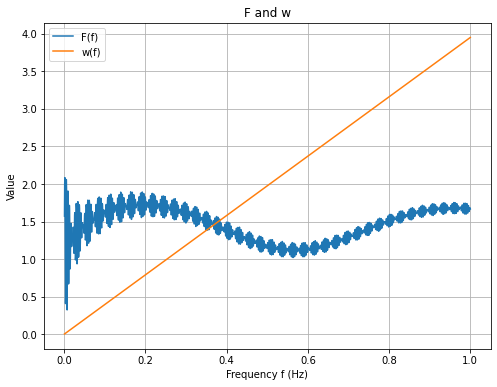

In [45]:


def F_fsis(w, y, Xmax=30.0, N=20000):
    phi_m = y + 0.5
    x = np.linspace(0, Xmax, N)
    dx = x[1] - x[0]

    phase = 0.5*x**2 - x + phi_m
    f = x * j0(w*x*y) * np.exp(1j * w * phase)

    # Filon/trapezoid hybrid
    I = np.trapz(f, x)

    return -1j * w * np.exp(1j * w * y**2 / 2) * I

# F(f) vs f
v = 100 # km/s
z_L = 0.2
z_S = 1.0
y = 1

freq_vals = np.linspace(0.001, 1, 2000)
MLz = M_Lz(v, z_L, z_S)
w_vals = w_f_sis(freq_vals, MLz, z_L)

amp_vals = np.array([F_fsis(w, y) for w in w_vals])
print(amp_vals)
print(w_vals)
plt.figure(figsize=(8, 6))
plt.plot(freq_vals, np.abs(amp_vals), label="F(f)")
plt.plot(freq_vals, w_vals, label="w(f)")
plt.grid(True)
plt.xlabel("Frequency f (Hz)")
plt.ylabel("Value")
plt.title("F and w")
plt.legend()
plt.show()

In [12]:
print("M_Lz =", MLz)
print("w(0.1) =", w_f_sis(0.1, MLz, z_L))
print("w(0.01) =", w_f_sis(0.01, MLz, z_L))



M_Lz = 95614.11884000973
w(0.1) = 3.94949361490223e-09
w(0.01) = 3.9494936149022296e-10
